In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import glob
import itertools
from SoilFlux_fun import get_variables_7810,get_variables_8100
from SoilFlux_fun import simple_QC,get_GPP_etc,plot_daily_flux_vs_collar
from SoilFlux_fun import get_metaData,get_VPRM_grass_R,linear_fit,remove_nan_for_fitting
import warnings
warnings.filterwarnings("ignore")
    
# Parameters

# ##########################################################  
#             Change if needed
# ########################################################## 
RawDatadir = "C:\\Users\\Min Tien\\Documents\\Python Scripts\\SoilFlux\\data\\Raw_Data_2022701\\"
Datadir = "C:\\Users\\Min Tien\\Documents\\Python Scripts\\SoilFlux\\data\\"
Outputdir = "C:\\Users\\Min Tien\\Documents\\Python Scripts\\SoilFlux\\data\\Output_dataframe\\"
Figdir = "C:\\Users\\Min Tien\\Documents\\Python Scripts\\SoilFlux\\fig\\"
# ########################################################## 

area_8100 = 314.0
vol_8100 = 4823.9
area_7810 = 318.0
vol_7810 = 4244.1
Labels_LDEO = ['LC_HL1', 'LC_HL2','LC_HL3','LC_HL4','LC_HL5','LC_HL6',
               'LH_UL1', 'LH_UL2','LH_UL3','LH_UL4','LH_UL5','LH_UL6',
               'LH_SV1', 'LH_SV2']
Labels_NYBG = np.array(['BW_TP1', 'BW_TP2', 'BW_TP3', 'BW_TP4',
               'BT_FE1', 'BT_FE2', 'BT_FE3', 'BT_FE4',
               'BT_FI1', 'BT_FI2', 'BT_FI3', 'BT_FI4',
               'BE_UL1', 'BE_UL2', 'BG_UL3', 'BG_UL4',
               'BL_SV1', 'BL_SV2', 'BE_SV3', 'BE_SV4',
               'BL_ML1', 'BL_ML2', 'BL_ML3', 'BL_ML4',
               'BW_HL1', 'BW_HL2', 'BR_HL3', 'BR_HL4',
               ])
EcoTypes = ['UL', 'ML', 'HL', 'SV', 'TP', 'FE', 'FI']
Colors = ['olivedrab', 'goldenrod', 'darkred', 'skyblue', 'chocolate', 'lime', 'darkgreen']
Labels_NYBG_sht = np.array([lab[3:6] for lab in Labels_NYBG])
Labels_LDEO_sht = np.array([lab[3:6] for lab in Labels_LDEO])
fMetaData = 'Metadata_0712.xlsx'
Excel_Columes = ['Collar', 'Time','Chamber','Height','Soil Temperature', 
               'Soil Moisture', 'PAR', 'Air temprature', 'instrument',
              'Vegetation %', 'Notes']

# ##########################################################  
#             Change if needed
# ########################################################## 
# All the dates we made measurements
files = glob.glob(Datadir+'*LDEO*')
Labels_generic = Labels_LDEO
# ########################################################## 

# Dates involved
AllDates = []
for file in files:
    AllDates.append(file[-22:-14])
# print(AllDates)

# sort the filenames by date
files = [i for _,i in sorted(zip(AllDates,files))]
for file in files:
    print(file)


C:\Users\Min Tien\Documents\Python Scripts\SoilFlux\data\20220610_LDEO_8100.csv
C:\Users\Min Tien\Documents\Python Scripts\SoilFlux\data\20220614_LDEO_8100.csv
C:\Users\Min Tien\Documents\Python Scripts\SoilFlux\data\20220617_LDEO_8100.csv
C:\Users\Min Tien\Documents\Python Scripts\SoilFlux\data\20220621_LDEO_8100.csv
C:\Users\Min Tien\Documents\Python Scripts\SoilFlux\data\20220629_LDEO_7810.csv
C:\Users\Min Tien\Documents\Python Scripts\SoilFlux\data\20220707_LDEO_7810.csv
C:\Users\Min Tien\Documents\Python Scripts\SoilFlux\data\20220711_LDEO_7810.csv
C:\Users\Min Tien\Documents\Python Scripts\SoilFlux\data\20220720_LDEO_7810.csv
C:\Users\Min Tien\Documents\Python Scripts\SoilFlux\data\20220720_LDEO_8100.csv
C:\Users\Min Tien\Documents\Python Scripts\SoilFlux\data\20220803_LDEO_7810.csv
C:\Users\Min Tien\Documents\Python Scripts\SoilFlux\data\20220818_LDEO_7810.csv
C:\Users\Min Tien\Documents\Python Scripts\SoilFlux\data\20220818_LDEO_8100.csv


In [2]:
MarkerSize = 12
LineWidth = 9
Allsamedates = [] # all the dates that have 8100 and 7810
AllDates = []     # contain all the dates info
AllDTR = []
AllDTNEE = []
AllLabels= []
AllFlx_R = []
AllFlx_NEE = []
AllFlx_NEE1 = []
AllFlx_NEE2 = []
AllFlx_GPP = []
AllPAR = []
AllSTemp = []
AllSMoist= []
AllATemp=[]
AllTchamber=[]
for file in files:
    Date = file[-22:-14]
    print(Date)
    files_same_day = glob.glob(Datadir+'*'+Date+'*')
    
    if len(files_same_day)==2:   # days when 8100 for NEE and 7810 for R
        if Date in Allsamedates:
            continue
            print('Already did for the date!!!')
        Allsamedates.append(Date)
        
        tag='7810+8100'
        files_same_day=np.array(files_same_day)
        file_7810 = files_same_day[['7810' in file for file in files_same_day]]
        file_8100 = files_same_day[['8100' in file for file in files_same_day]]
        DT, Labels, Flx_linear, Flx_expone, Flx_CV, bNEE, bR,Tcham8100 = get_variables_8100(file_8100[0])
        DT1, Labels1, Flx_linear1, Flx_expone1, Flx_CV1, bNEE1, bR1,Tcham7810 = get_variables_7810(file_7810[0])
        
        # Simple Quality Control
        Flx_real_8100 = simple_QC(Flx_CV, Flx_linear, Flx_expone)
        Flx_real_7810 = simple_QC(Flx_CV1, Flx_linear1, Flx_expone1)

        # Get GPP and other stuff
        Flx_GPP, Flx_R8, Flx_NEE8, Flx_NEE81, Flx_NEE82, DT_R, DT_NEE,Tchamber8100 = get_GPP_etc(
                    Labels, bR, bNEE, Flx_real_8100, DT,Labels_generic,Tcham8100)
        
        Flx_GPP1, Flx_R7, Flx_NEE1, Flx_NEE11, Flx_NEE12, DT_R1, DT_NEE,Tchamber7810 = get_GPP_etc(
                    Labels1, bR1, bNEE1, Flx_real_7810, DT1, Labels_generic, Tcham7810)
        
        Flx_R = Flx_R7
        Flx_NEE = Flx_NEE8
        Flx_NEE1 = Flx_NEE81
        Flx_NEE2 = Flx_NEE82
        Flx_GPP = -Flx_R+Flx_NEE
        DT_R = DT_R1
        DT_NEE = DT_NEE
        Tchamber = Tchamber7810
             
    elif len(files_same_day)==1:
        # Get variables
        if '8100' in file:
            DT, Labels, Flx_linear, Flx_expone, Flx_CV, bNEE, bR, Tcham= \
                                       get_variables_8100(file)
            tag='8100'
        elif '7810' in file:
            DT, Labels, Flx_linear, Flx_expone, Flx_CV, bNEE, bR,Tcham = \
                                       get_variables_7810(file)
            tag='7810'

        # Simple Quality Control
        Flx_real = simple_QC(Flx_CV, Flx_linear, Flx_expone)

        # Get GPP and other stuff
        Flx_GPP, Flx_R, Flx_NEE, Flx_NEE1, Flx_NEE2, DT_R, DT_NEE,Tchamber = \
        get_GPP_etc(Labels, bR, bNEE, Flx_real,DT, Labels_generic, Tcham)

    else:
        print('More than 2 files!!! Something is wrong!!!!')
    
    AllDates.append([Date]*len(Labels_generic))
    AllDTR.append(list(DT_R))
    AllDTNEE.append(list(DT_NEE))
    AllLabels.append(list(Labels_generic))
    AllFlx_R.append(list(Flx_R))
    AllFlx_NEE.append(list(Flx_NEE))
    AllFlx_NEE1.append(list(Flx_NEE1))
    AllFlx_NEE2.append(list(Flx_NEE2))
    AllFlx_GPP.append(list(Flx_GPP))
    AllTchamber.append(list(Tchamber))

    # Get the metadata
    Par, STemp, SMoist, ATemp = get_metaData(Date, Labels_generic)
    AllPAR.append(list(Par))
    AllSTemp.append(list(STemp))
    AllSMoist.append(list(SMoist))
    AllATemp.append(list(ATemp))
    
    # plot the daily data
    # plot_daily_flux_vs_collar(Flx_R, Flx_NEE, Flx_NEE1, Flx_GPP)

# Convert to 1D array
AllDates = np.ndarray.flatten(np.array(AllDates)) 
AllDTR   = np.ndarray.flatten(np.array(AllDTR)) 
AllDTNEE = np.ndarray.flatten(np.array(AllDTNEE)) 
AllLabels= np.ndarray.flatten(np.array(AllLabels))
AllFlx_R = np.ndarray.flatten(np.array(AllFlx_R))
AllFlx_NEE  = np.ndarray.flatten(np.array(AllFlx_NEE))
AllFlx_NEE1 = np.ndarray.flatten(np.array(AllFlx_NEE1))
AllFlx_NEE2 = np.ndarray.flatten(np.array(AllFlx_NEE2))
AllFlx_GPP  = np.ndarray.flatten(np.array(AllFlx_GPP))
AllTchamber = np.ndarray.flatten(np.array(AllTchamber))

AllPAR   = np.ndarray.flatten(np.array(AllPAR))
AllSTemp = np.ndarray.flatten(np.array(AllSTemp))
AllSMoist= np.ndarray.flatten(np.array(AllSMoist))
AllATemp = np.ndarray.flatten(np.array(AllATemp))

# Simple GPP quality control
# If GPP>0, GPP=nan
ind=0
for gpp in AllFlx_GPP:
    if ~np.isnan(gpp) and gpp>0.0:
        print('The GPP of', AllLabels[ind], 'on', AllDates[ind], 'is', AllFlx_GPP[ind])
        if AllFlx_GPP[ind]/AllFlx_R[ind]<0.3:
            AllFlx_GPP[ind]=0.0
            AllFlx_NEE[ind]= np.nan      # use R from 7810 just for consistency            
    ind+=1


# Save as a dataframe
Data = pd.DataFrame({"Date":AllDates, "DT_R": AllDTR, "DT_NEE": AllDTNEE,"Label":AllLabels,\
                       'Res':AllFlx_R,\
                       "NEE":AllFlx_NEE,"NEE1":AllFlx_NEE1,"NEE2":AllFlx_NEE2,\
                       "GEE":AllFlx_GPP,"PAR":AllPAR, "Soil temperature":AllSTemp,\
                       "Soil_moist":AllSMoist})

Data.to_csv(Outputdir+'LDEO_Carbon_fluxes')

# # Print data from a specific day
# ind=0
# for r in AllFlx_R:
#     if AllDates[ind]=='20220722':
#         print(AllLabels[ind], r)
#     ind+=1


20220610
20220614
20220617
20220621
20220629
20220707


ValueError: Worksheet named '220707' not found

(-42.0, 32.0)

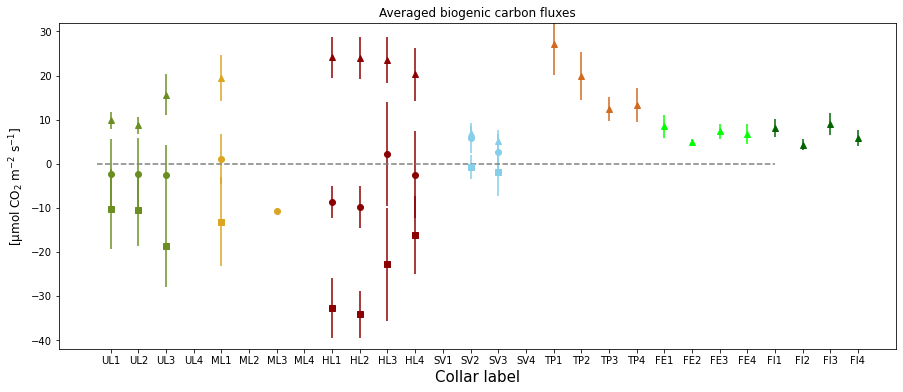

In [6]:
# The averages over time
fR_ave = []
fR_std = []
fNEE_ave = []
fNEE_std = []
fGPP_ave = []
fGPP_std = []
fR = []
for lab in Labels_generic:
    boo=[label==lab for label in AllLabels]
    
    # averages and standard deviations
    fR_ave.append(np.nanmean(AllFlx_R[boo]))
    fR_std.append(np.nanstd(AllFlx_R[boo]))
    fNEE_ave.append(np.nanmean(AllFlx_NEE[boo]))
    fNEE_std.append(np.nanstd(AllFlx_NEE[boo]))
    fGPP_ave.append(np.nanmean(AllFlx_GPP[boo]))
    fGPP_std.append(np.nanstd(AllFlx_GPP[boo]))

fR_ave=np.array(fR_ave)
fR_std=np.array(fR_std)
fNEE_ave=np.array(fNEE_ave)
fNEE_std=np.array(fNEE_std)
fGPP_ave=np.array(fGPP_ave)
fGPP_std=np.array(fGPP_std)

plt.figure(figsize=(15,6))
for eco in EcoTypes:
    boo_eco = np.array([eco in lab for lab in Labels_generic]) 
    Labels_sht = np.array([lab[3:6] for lab in Labels_generic])
    label_eco = Labels_sht[boo_eco]
    color_eco = Colors[EcoTypes.index(eco)]
    
    plt.errorbar(label_eco, fR_ave[boo_eco], fR_std[boo_eco], linestyle='none', marker='^', color=color_eco)
    plt.errorbar(label_eco, fNEE_ave[boo_eco], fNEE_std[boo_eco], linestyle='none', marker='o', color=color_eco)
    plt.errorbar(label_eco, fGPP_ave[boo_eco], fGPP_std[boo_eco], linestyle='none', marker='s', color=color_eco)
    
plt.plot([-0.5, 24], [0,0], linestyle='--', color='grey') 
plt.title('Averaged biogenic carbon fluxes')  
plt.ylabel('[\u03BCmol CO$_{2}$ m$^{-2}$ s$^{-1}]$', fontsize=12)
plt.xlabel('Collar label', fontsize=15)
plt.ylim(-42, 32)


[datetime.datetime(2022, 5, 23, 0, 0), datetime.datetime(2022, 5, 31, 0, 0), datetime.datetime(2022, 6, 7, 0, 0), datetime.datetime(2022, 6, 15, 0, 0), datetime.datetime(2022, 6, 28, 0, 0), datetime.datetime(2022, 7, 1, 0, 0), datetime.datetime(2022, 7, 6, 0, 0), datetime.datetime(2022, 7, 22, 0, 0), datetime.datetime(2022, 8, 4, 0, 0), datetime.datetime(2022, 8, 16, 0, 0), datetime.datetime(2022, 8, 31, 0, 0), datetime.datetime(2022, 9, 15, 0, 0)]


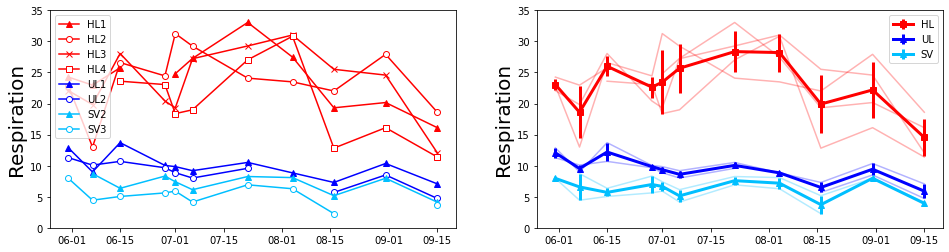

In [10]:
# Seasonality
def get_NEE_one_collar(lll):
    boo_lab = [lll in label for label in AllLabels]
    return AllFlx_NEE[boo_lab]

def get_Res_one_collar(lll):
    boo_lab = [lll in label for label in AllLabels]
    return AllFlx_R[boo_lab]

def get_GPP_one_collar(lll):
    boo_lab = [lll in label for label in AllLabels]
    GPP=AllFlx_GPP[boo_lab]
    GPP[GPP>0]=0.0
    return GPP

def get_dates_one_collar(lll):
    boo_lab = [lll in label for label in AllLabels]
    return AllDates[boo_lab]

def get_Tchamber_one_collar(lll):
    boo_lab = [lll in label for label in AllLabels]
    return AllTchamber[boo_lab]

def get_PAR_one_collar(lll):
    boo_lab = [lll in label for label in AllLabels]
    return AllPAR[boo_lab]

# Dates
Dates=get_dates_one_collar('HL1')
dt_Dates = [dt.datetime.strptime(d, '%Y%m%d') for d in Dates]
print(dt_Dates)

# Hot lawns 1-4
R_HL1=get_Res_one_collar('HL1')
R_HL2=get_Res_one_collar('HL2')
R_HL3=get_Res_one_collar('HL3')
R_HL4=get_Res_one_collar('HL4')
R_HL12_ave=np.nanmean([R_HL1,R_HL2], axis=0)
R_HL12_std=np.nanstd([R_HL2,R_HL1], axis=0)
R_HL34_ave=np.nanmean([R_HL3,R_HL4], axis=0)
R_HL34_std=np.nanstd([R_HL3,R_HL4], axis=0)
R_HLall_ave=np.nanmean([R_HL1,R_HL2,R_HL3,R_HL4], axis=0)
R_HLall_std=np.nanstd([R_HL1,R_HL2,R_HL3,R_HL4], axis=0)

Tc_HL1=get_Tchamber_one_collar('HL1')
Tc_HL2=get_Tchamber_one_collar('HL2')
Tc_HL3=get_Tchamber_one_collar('HL3')
Tc_HL4=get_Tchamber_one_collar('HL4')
Tc_UL1=get_Tchamber_one_collar('UL1')
Tc_UL2=get_Tchamber_one_collar('UL2')
Tc_SV2=get_Tchamber_one_collar('SV2')

PAR_HL1 = get_PAR_one_collar('HL1')
PAR_HL2 = get_PAR_one_collar('HL2')
PAR_HL3 = get_PAR_one_collar('HL3')
PAR_HL4 = get_PAR_one_collar('HL4')

# Unmanaged lawns 1-4
R_UL1=get_Res_one_collar('UL1')
R_UL2=get_Res_one_collar('UL2')
R_UL3=get_Res_one_collar('UL3')
R_UL_ave=np.nanmean([R_UL1,R_UL2], axis=0)
R_UL_std=np.nanstd([R_UL1,R_UL2], axis=0)

# Managed lawn
R_ML1=get_Res_one_collar('ML1')

# Savanna 2-3
R_SV2=get_Res_one_collar('SV2')
R_SV3=get_Res_one_collar('SV3')
R_SV_ave=np.nanmean([R_SV3,R_SV2], axis=0)
R_SV_std=np.nanstd([R_SV3,R_SV2], axis=0)

# Forest
R_FI1=get_Res_one_collar('FI1')
R_FI2=get_Res_one_collar('FI2')
R_FI3=get_Res_one_collar('FI3')
R_FI4=get_Res_one_collar('FI4')

R_FE1=get_Res_one_collar('FE1')
R_FE2=get_Res_one_collar('FE2')
R_FE3=get_Res_one_collar('FE3')
R_FE4=get_Res_one_collar('FE4')

# Lawns
fig, ax = plt.subplots(1,2,figsize=(16, 4))
myFmt = mdates.DateFormatter('%m-%d')
Alpha=0.3
LineWidth=3

ax[0].plot(dt_Dates, R_HL1, color='r', marker='^',label='HL1')
ax[0].plot(dt_Dates, R_HL2, color='r', marker='o', label='HL2', markerfacecolor='w')
ax[0].plot(dt_Dates, R_HL3, color='r', marker='x',label='HL3')
ax[0].plot(dt_Dates, R_HL4, color='r', marker='s', label='HL4', markerfacecolor='w')

ax[0].plot(dt_Dates, R_UL1, color='b', marker='^',label='UL1')
ax[0].plot(dt_Dates, R_UL2, color='b', marker='o', label='UL2', markerfacecolor='w')

ax[0].plot(dt_Dates, R_SV2, color='deepskyblue', marker='^',label='SV2')
ax[0].plot(dt_Dates, R_SV3, color='deepskyblue', marker='o', label='SV3', markerfacecolor='w')

ax[0].set_ylim(0., 35)
ax[0].set_ylabel('Respiration', FontSize=20)
ax[0].legend(loc='upper left')
ax[0].xaxis.set_major_formatter(myFmt)

# Averages
# ax[1].errorbar(dt_Dates, R_HL12_ave, R_HL12_std, color='r', marker='^',label='HL12')
# ax[1].errorbar(dt_Dates, R_HL34_ave, R_HL34_std, color='r', marker='s',label='HL34',markerfacecolor='w')
ax[1].errorbar(dt_Dates, R_HLall_ave, R_HLall_std, color='r', marker='s',label='HL', linewidth=LineWidth)
ax[1].errorbar(dt_Dates, R_UL_ave, R_UL_std, color='b', marker='^',label='UL', linewidth=LineWidth)
ax[1].errorbar(dt_Dates, R_SV_ave, R_SV_std, color='deepskyblue', marker='^',label='SV', linewidth=LineWidth)

ax[1].plot(dt_Dates, R_HL1, color='r', alpha=Alpha)
ax[1].plot(dt_Dates, R_HL2, color='r', markerfacecolor='w', alpha=Alpha)
ax[1].plot(dt_Dates, R_HL3, color='r', alpha=Alpha)
ax[1].plot(dt_Dates, R_HL4, color='r', markerfacecolor='w', alpha=Alpha)
ax[1].plot(dt_Dates, R_UL1, color='b', alpha=Alpha)
ax[1].plot(dt_Dates, R_UL2, color='b', markerfacecolor='w', alpha=Alpha)
ax[1].plot(dt_Dates, R_SV2, color='deepskyblue', alpha=Alpha)
ax[1].plot(dt_Dates, R_SV3, color='deepskyblue', markerfacecolor='w', alpha=Alpha)

ax[1].set_ylim(0., 35)
ax[1].set_ylabel('Respiration', FontSize=20)
ax[1].legend(loc='upper right')
ax[1].xaxis.set_major_formatter(myFmt)


No handles with labels found to put in legend.


(-50.0, 5.0)

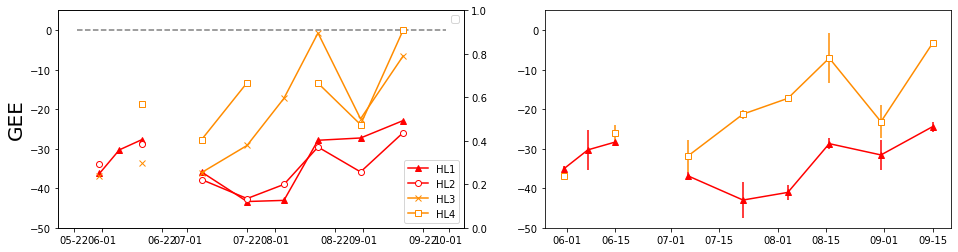

In [11]:
# GEE
# Hot lawns
GEE_HL1=get_GPP_one_collar('HL1')
GEE_HL2=get_GPP_one_collar('HL2')
GEE_HL3=get_GPP_one_collar('HL3')
GEE_HL4=get_GPP_one_collar('HL4')
GEE_HL12_ave = np.nanmean([GEE_HL1, GEE_HL2],axis=0)
GEE_HL12_std = np.nanstd([GEE_HL1, GEE_HL2],axis=0)
GEE_HL34_ave = np.nanmean([GEE_HL3, GEE_HL4],axis=0)
GEE_HL34_std = np.nanstd([GEE_HL3, GEE_HL4],axis=0)

# Unmanaged lawns 1,2
GEE_UL1=get_GPP_one_collar('UL1')
GEE_UL2=get_GPP_one_collar('UL2')
GEE_UL_ave = np.nanmean([GEE_UL1, GEE_UL2],axis=0)
GEE_UL_std = np.nanstd([GEE_UL1, GEE_UL2],axis=0)

# Savanna
GEE_SV3=get_GPP_one_collar('SV3')
GEE_SV2=get_GPP_one_collar('SV2')
GEE_SV_ave = np.nanmean([GEE_SV3, GEE_SV2],axis=0)
GEE_SV_std = np.nanstd([GEE_SV3, GEE_SV2],axis=0)

# lawn NEE
fig, ax = plt.subplots(1,2,figsize=(16, 4))
ax[0].plot([dt.date(2022,5,23), dt.date(2022,9,30)], [0,0], color='grey', linestyle='--')
ax[0].plot(dt_Dates, GEE_HL1, color='r', marker='^',label='HL1')
ax[0].plot(dt_Dates, GEE_HL2, color='r', marker='o',label='HL2', markerfacecolor='w')
ax[0].plot(dt_Dates, GEE_HL3, color='darkorange', marker='x',label='HL3')
ax[0].plot(dt_Dates, GEE_HL4, color='darkorange', marker='s',label='HL4', markerfacecolor='w')

axtw = ax[0].twinx()
# axtw.plot(dt_Dates, PAR_HL1, color='k',label='PAR_HL1')
# axtw.plot(dt_Dates, PAR_HL2, color='purple', label='PAR_HL2', markerfacecolor='w')

# ax[0].plot(dt_Dates, GEE_UL1, color='b', marker='^',label='UL1')
# ax[0].plot(dt_Dates, GEE_UL2, color='b', marker='o', label='UL2', markerfacecolor='w')

# ax[0].plot(dt_Dates, GEE_SV2, color='deepskyblue', marker='^',label='SV2')
# ax[0].plot(dt_Dates, GEE_SV3, color='deepskyblue', marker='o', label='SV3', markerfacecolor='w')

ax[0].set_ylim(-50, 5)
ax[0].set_ylabel('GEE', FontSize=20)
ax[0].legend(loc='upper left')
axtw.legend()

ax[0].xaxis.set_major_formatter(myFmt)
ax[0].legend(loc='lower right')

# Averages
ax[1].errorbar(dt_Dates, GEE_HL12_ave, R_HL12_std, color='r', marker='^',label='HL12')
ax[1].errorbar(dt_Dates, GEE_HL34_ave, R_HL34_std, color='darkorange', marker='s',label='HL34',markerfacecolor='w')
# ax[1].errorbar(dt_Dates, GEE_UL_ave, R_UL_std, color='b', marker='^',label='UL')
# ax[1].errorbar(dt_Dates, GEE_SV_ave, R_SV_std, color='deepskyblue', marker='^',label='SV')

ax[1].xaxis.set_major_formatter(myFmt)
ax[1].set_ylim(-50, 5)


-43.11822385630719


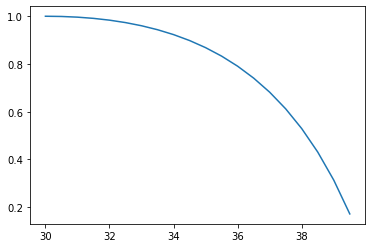

In [12]:
# VPRM GEE for grassland
def Ts_fun(Ta):
    Tmp = (Ta-2)*(Ta-40)
    return Tmp/(Tmp-(Ta-30)**2)

Ttest = np.arange(30, 40, 0.5)
Tscale= [Ts_fun(t) for t in Ttest]
plt.plot(Ttest, Tscale)

Pscale=0.6
Wscale=0.95
lamb  = 0.213
EVI   = 0.9
Tscale=Ts_fun(33)
PAR0  = 542.0
PAR   = 1700.0
GEE_test = -lamb*EVI*Tscale*PAR/(1+PAR/PAR0)*Pscale*Wscale

print(GEE_test)


Text(0.5, 0, 'Air temperature')

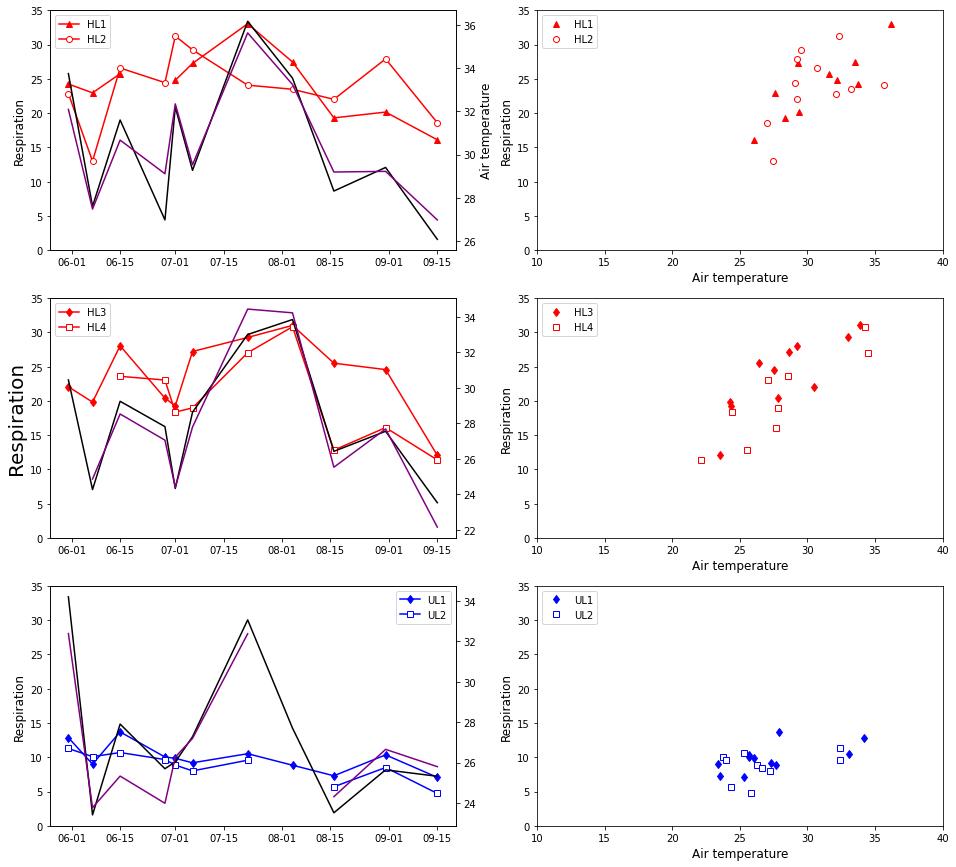

In [13]:
# Hot lawns and air temperature
# Lawns
fig, ax = plt.subplots(3,2,figsize=(16, 15))
myFmt = mdates.DateFormatter('%m-%d')
FontSize = 12

####################################################################################################
#
#                                         Hot lawn 1-2
#
####################################################################################################
ax[0,0].plot(dt_Dates, R_HL1, color='r', marker='^',label='HL1')
ax[0,0].plot(dt_Dates, R_HL2, color='r', marker='o', label='HL2', markerfacecolor='w')
axtw = ax[0,0].twinx()
axtw.plot(dt_Dates, Tc_HL1, color='k')
axtw.plot(dt_Dates, Tc_HL2, color='purple')

ax[0,0].set_ylim(0., 35)
ax[0,0].set_ylabel('Respiration', FontSize=FontSize)
ax[0,0].legend(loc='upper left')
ax[0,0].xaxis.set_major_formatter(myFmt)
axtw.set_ylabel('Air temperature', FontSize=FontSize)

# scatter 1-2
ax[0,1].plot(Tc_HL1, R_HL1, color='r', marker='^', label='HL1', linestyle='none')
ax[0,1].plot(Tc_HL2, R_HL2, color='r', marker='o', label='HL2', linestyle='none',markerfacecolor='w')

ax[0,1].set_ylim(0., 35)
ax[0,1].set_xlim(10., 40)
ax[0,1].legend(loc='upper left')
ax[0,1].set_ylabel('Respiration',FontSize=FontSize)
ax[0,1].set_xlabel('Air temperature',FontSize=FontSize)

####################################################################################################
#
#                                         Hot lawn 3-4
#
####################################################################################################
ax[1,0].plot(dt_Dates, R_HL3, color='r', marker='d',label='HL3')
ax[1,0].plot(dt_Dates, R_HL4, color='r', marker='s', label='HL4', markerfacecolor='w')
axtw = ax[1,0].twinx()
axtw.plot(dt_Dates, Tc_HL3, color='k',label='Tc_3')
axtw.plot(dt_Dates, Tc_HL4, color='purple', label='Tc_4', markerfacecolor='w')

ax[1,0].set_ylim(0., 35)
ax[1,0].set_ylabel('Respiration', FontSize=20)
ax[1,0].legend(loc='upper left')
ax[1,0].xaxis.set_major_formatter(myFmt)

# scatter 3-4
ax[1,1].plot(Tc_HL3, R_HL3, color='r', marker='d', label='HL3', linestyle='none')
ax[1,1].plot(Tc_HL4, R_HL4, color='r', marker='s', label='HL4', linestyle='none',markerfacecolor='w')
# ax[1,1].plot(Tc_HL1, R_HL1, color='b', marker='^', label='HL1', linestyle='none',markerfacecolor='w')
# ax[1,1].plot(Tc_HL2, R_HL2, color='b', marker='d', label='HL2', linestyle='none')

ax[1,1].set_ylim(0., 35)
ax[1,1].set_xlim(10., 40)
ax[1,1].legend(loc='upper left')
ax[1,1].set_ylabel('Respiration',FontSize=FontSize)
ax[1,1].set_xlabel('Air temperature',FontSize=FontSize)

####################################################################################################
#
#                                         Unmanaged lawn 1-2
#
####################################################################################################
ax[2,0].plot(dt_Dates, R_UL1, color='b', marker='d',label='UL1')
ax[2,0].plot(dt_Dates, R_UL2, color='b', marker='s', label='UL2', markerfacecolor='w')
axtw = ax[2,0].twinx()
axtw.plot(dt_Dates, Tc_UL1, color='k',label='Tc_3')
axtw.plot(dt_Dates, Tc_UL2, color='purple', label='Tc_4', markerfacecolor='w')

ax[2,0].set_ylim(0., 35)
ax[2,0].set_ylabel('Respiration', FontSize=FontSize)
ax[2,0].legend(loc='upper right')
ax[2,0].xaxis.set_major_formatter(myFmt)

# scatter for Unmanaged
ax[2,1].plot(Tc_UL1, R_UL1, color='b', marker='d', label='UL1', linestyle='none')
ax[2,1].plot(Tc_UL2, R_UL2, color='b', marker='s', label='UL2', linestyle='none',markerfacecolor='w')

ax[2,1].set_ylim(0., 35)
ax[2,1].set_xlim(10., 40)
ax[2,1].legend(loc='upper left')
ax[2,1].set_ylabel('Respiration',FontSize=FontSize)
ax[2,1].set_xlabel('Air temperature',FontSize=FontSize)


(slope,intercept,r) are 1.26 -13.75 0.82 for hot lawns
(slope,intercept,r) are 0.32 0.74 0.49 for unmanaged lawns


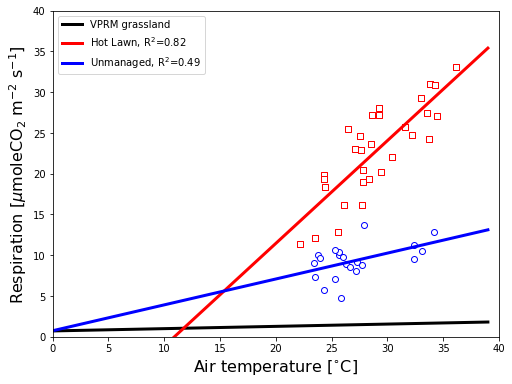

In [14]:
from scipy import stats

Ta_vprm = np.arange(0,40.0)
alpha_vprm=0.028 
beta_vprm=0.72

def linear_fit(x,y):
    boo_x = ~np.isnan(x)
    boo_y = ~np.isnan(y)
    boo=np.logical_and(boo_x,boo_y)
    slope, intercept, r, p, std_err = stats.linregress(x[boo],y[boo])
    return slope,intercept, r

def myfunc(x, slope, intercept):
    return slope * x + intercept

def vprmfunc(x):
    return alpha_vprm * x + beta_vprm

vprmmodel= list(map(vprmfunc, Ta_vprm))
Tc_HL_tot=np.array(list(Tc_HL1)+list(Tc_HL3)+list(Tc_HL4))
R_HL_tot=np.array(list(R_HL1)+list(R_HL3)+list(R_HL4))

Tc_UL_tot=np.array(list(Tc_UL1)+list(Tc_UL2))
R_UL_tot=np.array(list(R_UL1)+list(R_UL2))

S_HL1,In_HL1,R2_HL1=linear_fit(Tc_HL1,R_HL1)
S_HL2,In_HL2,R2_HL2=linear_fit(Tc_HL2,R_HL2)
S_HL3,In_HL3,R2_HL3=linear_fit(Tc_HL3,R_HL3)
S_HL4,In_HL4,R2_HL4=linear_fit(Tc_HL4,R_HL4)
S_HL_tot,In_HL_tot,R2_HL_tot=linear_fit(Tc_HL_tot,R_HL_tot)

MyModel_HL1 = myfunc(Ta_vprm, S_HL1, In_HL1)
MyModel_HL2 = myfunc(Ta_vprm, S_HL2, In_HL2)
MyModel_HL3 = myfunc(Ta_vprm, S_HL3, In_HL3)
MyModel_HL4 = myfunc(Ta_vprm, S_HL4, In_HL4)
MyModel_HL_tot = myfunc(Ta_vprm, S_HL_tot, In_HL_tot)

S_UL1,In_UL1,R2_UL1=linear_fit(Tc_UL1,R_UL1)
S_UL2,In_UL2,R2_UL2=linear_fit(Tc_UL2,R_UL2)
S_UL_tot,In_UL_tot,R2_UL_tot=linear_fit(Tc_UL_tot,R_UL_tot)

MyModel_UL1 = myfunc(Ta_vprm, S_UL1, In_UL1)
MyModel_UL2 = myfunc(Ta_vprm, S_UL2, In_UL2)
MyModel_UL_tot = myfunc(Ta_vprm, S_UL_tot, In_UL_tot)

fig,ax=plt.subplots(1,figsize=(8,6))
LineWidth=3
FontSize=16

ax.plot(Ta_vprm, vprmmodel, color='black', label='VPRM grassland', linewidth=LineWidth)

# ax.plot(Ta_vprm,MyModel_HL1, color='r', markerfacecolor='w', label='HL1')
# ax.plot(Ta_vprm,MyModel_HL2, color='y', markerfacecolor='w', label='HL2')
# ax.plot(Ta_vprm,MyModel_HL3, color='g', markerfacecolor='w', label='HL3')
# ax.plot(Ta_vprm,MyModel_HL4, color='b', markerfacecolor='w', label='HL4')
ax.plot(Ta_vprm,MyModel_HL_tot, color='r', markerfacecolor='w', 
        label='Hot Lawn, R$^{2}$='+str(np.round(R2_HL_tot, 2)), linewidth=LineWidth)
ax.scatter(Tc_HL_tot,R_HL_tot, color='r', marker='s', facecolor='w')

# ax.plot(Ta_vprm,MyModel_UL1, color='b', markerfacecolor='w', label='UL1')
# ax.plot(Ta_vprm,MyModel_UL2, color='cyan', markerfacecolor='w', label='UL2')
ax.plot(Ta_vprm,MyModel_UL_tot, color='b', markerfacecolor='w', 
        label='Unmanaged, R$^{2}$='+str(np.round(R2_UL_tot, 2)), linewidth=LineWidth)
ax.scatter(Tc_UL_tot,R_UL_tot, color='b', facecolor='w', marker='o')

ax.set_ylim(0,40)
ax.set_xlim(0,40)
ax.set_xlabel('Air temperature [$^{\circ}$C]', Fontsize=FontSize)
ax.set_ylabel('Respiration [$\mu$moleCO$_{2}$ m$^{-2}$ s$^{-1}$]', Fontsize=FontSize)
ax.legend(loc='upper left')

print('(slope,intercept,r) are %3.2f %3.2f %3.2f for hot lawns' %(S_HL_tot,In_HL_tot,R2_HL_tot))
print('(slope,intercept,r) are %3.2f %3.2f %3.2f for unmanaged lawns' %(S_UL_tot,In_UL_tot,R2_UL_tot))


[19.44444444 26.11111111 21.38888889 23.61111111 22.5        27.77777778
 25.55555556 30.         29.16666667 23.61111111 25.         20.        ]
[datetime.datetime(2022, 5, 23, 0, 0), datetime.datetime(2022, 5, 31, 0, 0), datetime.datetime(2022, 6, 7, 0, 0), datetime.datetime(2022, 6, 15, 0, 0), datetime.datetime(2022, 6, 28, 0, 0), datetime.datetime(2022, 7, 1, 0, 0), datetime.datetime(2022, 7, 6, 0, 0), datetime.datetime(2022, 7, 22, 0, 0), datetime.datetime(2022, 8, 4, 0, 0), datetime.datetime(2022, 8, 16, 0, 0), datetime.datetime(2022, 8, 31, 0, 0), datetime.datetime(2022, 9, 15, 0, 0)]


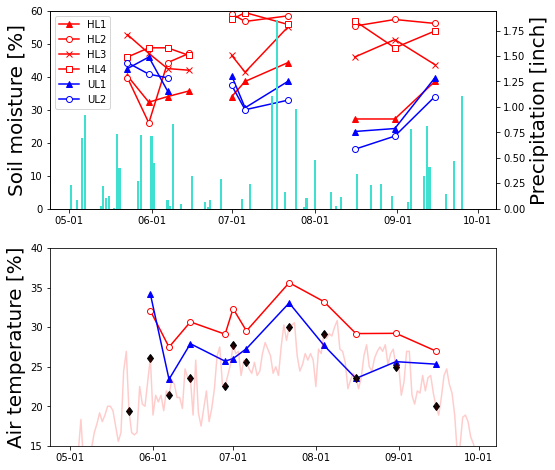

In [15]:
# Daily weather data from NOAA
def f_to_c(x):
    return (x-32.0)*5.0/9.0

DailyWeatherDir='/Users/dandanwei/Desktop/Measurements-2022/SoilFlux/data/NYC_daily_weather/'
weatherfile = 'NYC_central_park_daily.xlsx'
WeatherData=pd.read_excel(DailyWeatherDir+weatherfile, header=0)
WeatherData = WeatherData.to_numpy()
dstr_weather = WeatherData[:,0]
dt_weather= np.array([pd.Timestamp.to_pydatetime(ds) for ds in dstr_weather])
T_daily=WeatherData[:,3]
P_daily=WeatherData[:,7]
P_daily[P_daily<0] = np.nan
T_daily=np.array([f_to_c(t) for t in T_daily])
T_daily_NYBG = np.ndarray.flatten(np.array([T_daily[dt_weather==d] for d in dt_Dates]))# the daily air temperature on the measurement days
print(T_daily_NYBG)

# Weather data from NYBG
def get_PAR_one_collar(lll):
    boo_lab = [lll in label for label in AllLabels]
    return AllPAR[boo_lab]

def get_SoilTemp_one_collar(lll):
    boo_lab = [lll in label for label in AllLabels]
    return AllSTemp[boo_lab]

def get_SoilMoist_one_collar(lll):
    boo_lab = [lll in label for label in AllLabels]
    return AllSMoist[boo_lab]

# Dates
Dates=get_dates_one_collar('HL1')
dt_Dates = [dt.datetime.strptime(d, '%Y%m%d') for d in Dates]
print(dt_Dates)

Tc_HL1=get_Tchamber_one_collar('HL1')
Tc_HL2=get_Tchamber_one_collar('HL2')
Tc_HL3=get_Tchamber_one_collar('HL3')
Tc_HL4=get_Tchamber_one_collar('HL4')
Tc_UL1=get_Tchamber_one_collar('UL1')
Tc_UL2=get_Tchamber_one_collar('UL2')

PAR_HL1 = get_PAR_one_collar('HL1')
PAR_HL2 = get_PAR_one_collar('HL2')
PAR_HL3 = get_PAR_one_collar('HL3')
PAR_HL4 = get_PAR_one_collar('HL4')

ST_HL1 = get_SoilTemp_one_collar('HL1')
ST_HL2 = get_SoilTemp_one_collar('HL2')
ST_HL3 = get_SoilTemp_one_collar('HL3')
ST_HL4 = get_SoilTemp_one_collar('HL4')
ST_UL1 = get_SoilTemp_one_collar('UL1')
ST_UL2 = get_SoilTemp_one_collar('UL2')

SM_HL1 = get_SoilMoist_one_collar('HL1')
SM_HL2 = get_SoilMoist_one_collar('HL2')
SM_HL3 = get_SoilMoist_one_collar('HL3')
SM_HL4 = get_SoilMoist_one_collar('HL4')
SM_UL1 = get_SoilMoist_one_collar('UL1')
SM_UL2 = get_SoilMoist_one_collar('UL2')

# Lawns
fig, ax = plt.subplots(2,1,figsize=(8, 8))
myFmt = mdates.DateFormatter('%m-%d')
Alpha=0.3
LineWidth=3

# Moisture
ax[0].plot(dt_Dates, SM_HL1, color='r', marker='^',label='HL1')
ax[0].plot(dt_Dates, SM_HL2, color='r', marker='o', label='HL2', markerfacecolor='w')
ax[0].plot(dt_Dates, SM_HL3, color='r', marker='x',label='HL3')
ax[0].plot(dt_Dates, SM_HL4, color='r', marker='s', label='HL4', markerfacecolor='w')

ax[0].plot(dt_Dates, SM_UL1, color='b', marker='^',label='UL1')
ax[0].plot(dt_Dates, SM_UL2, color='b', marker='o', label='UL2', markerfacecolor='w')

axtwinx = ax[0].twinx()
axtwinx.bar(dt_weather, P_daily, color='turquoise')
axtwinx.set_ylabel('Precipitation [inch]', FontSize=20)

ax[0].set_ylim(0., 60)
ax[0].set_ylabel('Soil moisture [%]', FontSize=20)
ax[0].legend(loc='upper left')
ax[0].xaxis.set_major_formatter(myFmt)

# Temperature
# ax[1].plot(dt_Dates, Tc_HL1, color='r', marker='^',label='HL1')
ax[1].plot(dt_Dates, Tc_HL2, color='r', marker='o', label='HL2', markerfacecolor='w')
# ax[1].plot(dt_Dates, Tc_HL3, color='r', marker='x',label='HL3')
# ax[1].plot(dt_Dates, Tc_HL4, color='r', marker='s', label='HL4', markerfacecolor='w')
ax[1].plot(dt_Dates, Tc_UL1, color='b', marker='^',label='UL1')
# ax[1].plot(dt_Dates, Tc_UL2, color='b', marker='o', label='UL2', markerfacecolor='w')
ax[1].plot(dt_Dates, T_daily_NYBG, color='k', marker='d', label='daily', linestyle='none')

ax[1].plot(dt_weather, T_daily, color='r', alpha=0.2)

# ax[1].plot(dt_Dates, ST_HL1, color='r', marker='^',label='HL1', linestyle='--')
# ax[1].plot(dt_Dates, ST_HL2, color='r', marker='o', label='HL2', markerfacecolor='w', linestyle='--')
# ax[1].plot(dt_Dates, ST_HL3, color='r', marker='x',label='HL3', linestyle='--')
# ax[1].plot(dt_Dates, ST_HL4, color='r', marker='s', label='HL4', markerfacecolor='w', linestyle='--')
# ax[1].plot(dt_Dates, ST_UL1, color='b', marker='^',label='UL1', linestyle='--')
# ax[1].plot(dt_Dates, ST_UL2, color='b', marker='o', label='UL2', markerfacecolor='w', linestyle='--')

ax[1].set_ylim(15., 40)
ax[1].set_ylabel('Air temperature [%]', FontSize=20)
# ax[1].legend(loc='lower left')
ax[1].xaxis.set_major_formatter(myFmt)

